In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
torch.cuda.set_device(device)

In [4]:
from utils import load_cifar10, load_cifar100, load_tinyimagenet

In [5]:
# load cifar10 data
trainloader, testloader = load_cifar10(data_dir="../data/cifar10", batch_size=128, 
                                       test_batch = 128,train_shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
from utils import train_valid_split

In [7]:
# load dataloader for steal
stealloader,st_testloader = load_cifar100(data_dir="../data/cifar100", batch_size=128, train_shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
st_trloader, st_valloader = train_valid_split(stealloader,10000)

total data: 10000


In [9]:
# load tinyimagenet for outlier exposure
outlier_loader = load_tinyimagenet(data_dir="../data/tiny-imagenet-200",
                                   batch_size=128, train_shuffle=True)

In [33]:
class args:
    save_dir = "../results"
    orig_model = "cifar_orig_logit.pth"
#     fake_model = "cifar_fake_random_net.pth"
#     fake_model = "cifar_fake_logit_ML.pth"
    fake_model = "cifar_fake_logit_ML_swd.pth"
    tau = 0.8
#     nb_stolen = 10000 # attack model 학습시 사용할 데이터 수
#     st_trloader = "attnet_trloader.dl"
#     st_valloader = "attnet_valloader.dl"
#     att_epochs = 300
    att_model = "cifar_attacknet_logit_ml_tau%.1f.pth"%(tau)

In [34]:
args.att_model

'cifar_attacknet_logit_ml_tau0.8.pth'

In [35]:
from cifar_models import Net, Net_logit, AttackNet
from utils import CombNet, CombNet_logit, Net_softmax

In [36]:
import os
net = AttackNet()
net.load_state_dict(torch.load(os.path.join(args.save_dir,args.orig_model),map_location='cpu'))
net = Net_softmax(net)

net_fake = AttackNet()
net_fake.load_state_dict(torch.load(os.path.join(args.save_dir,args.fake_model),map_location='cpu'))
net_fake = Net_softmax(net_fake)

comb_net = CombNet(net, net_fake, args.tau)

In [37]:
from torch.utils.data import TensorDataset, DataLoader
def make_adaptive_loader(model_prob, victim_net, dataloader, tau, device, batch_size=128, shuffle=True):

    model_prob.to(device).eval()
    victim_net.to(device).eval()
    labels = []
    ori_out = []
    with torch.no_grad():
        for x,y in dataloader:
            with torch.no_grad():
                out = victim_net(x.to(device)).detach().cpu()
                ori_out.append(out)
            pred = torch.max(model_prob(x.to(device)).detach().cpu(),axis=1)
#             print(pred)
            labels.append(torch.tensor(pred[0]>tau).float())
            del x,y,pred, out
    data = torch.cat(ori_out,dim=0)
    labels = torch.cat(labels,dim=0)
    dataloader_ = DataLoader(TensorDataset(data, labels),batch_size=batch_size, shuffle=shuffle)
    model_prob.cpu()
    victim_net.cpu()
    return dataloader_
            
    

In [38]:
# attack with true tau for combnet
adpt_trloader = make_adaptive_loader(net, comb_net, st_trloader,comb_net.tau,device, batch_size=128, shuffle=True)
adpt_teloader = make_adaptive_loader(net, comb_net, st_valloader,comb_net.tau,device, batch_size=128, shuffle=False)
adpt_teloader2 = make_adaptive_loader(net, comb_net, testloader,comb_net.tau,device, batch_size=128, shuffle=False)

<ipython-input-37-377d5d037d5f>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(pred[0]>tau).float())


In [16]:
from livelossplot import PlotLosses
import torch.nn.functional as F
from utils import test_binary_model
def train_adapt_model(adpt_att_model, adpt_loader, criterion, optimizer, epochs, device, adpt_testloader = None, save_dir = "../results", save_model = "cifar_adapt_model.pth"):
    adpt_att_model.to(device)
    
    logs_clf = {}
    best_acc = 0.0
    liveloss_tr = PlotLosses()
    
    for epoch in range(epochs):
        adpt_att_model.train()
        
        for x,y in adpt_loader:

            adpt_att_model.zero_grad()

            out = adpt_att_model(x.to(device))
            loss = criterion(out.flatten().float(), y.to(device).float())
            
            loss.backward()
            optimizer.step()
            
            del x,out,  y, loss
            torch.cuda.empty_cache()
        logs_clf['loss'], logs_clf['acc']= test_binary_model(adpt_att_model, adpt_loader, criterion, device, 100.0, save_dir, save_model)
        if adpt_testloader is not None:
            logs_clf['val_loss'], logs_clf['val_acc']= test_binary_model(adpt_att_model, adpt_testloader, criterion, device, 0.0, save_dir, save_model)
        liveloss_tr.update(logs_clf)
        liveloss_tr.send()
    adpt_att_model.cpu()
    return adpt_att_model, logs_clf

In [17]:
NUM_CLASSES = 10
class Net_Adapt(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(Net_Adapt, self).__init__()
        self.num_input = num_classes
        self.lin1 = nn.Linear(self.num_input, 128)
        self.lin2 = nn.Linear(128,64)
        self.lin3 = nn.Linear(64,64)
        self.lin4 = nn.Linear(64,1)
    def forward(self,x):
        x = x.view(-1,self.num_input)
        x = F.relu(self.lin1(x))
        x = nn.Dropout(0.3)(x)
        x = F.relu(self.lin2(x))
        x = nn.Dropout(0.2)(x)
        x = F.relu(self.lin3(x))
        x = torch.sigmoid(self.lin4(x)).flatten()
        return x

In [39]:
adpt_att_net = Net_Adapt()
adpt_criterion = nn.BCELoss()
adpt_optimizer = optim.Adam(adpt_att_net.parameters())
adpt_epochs = 300

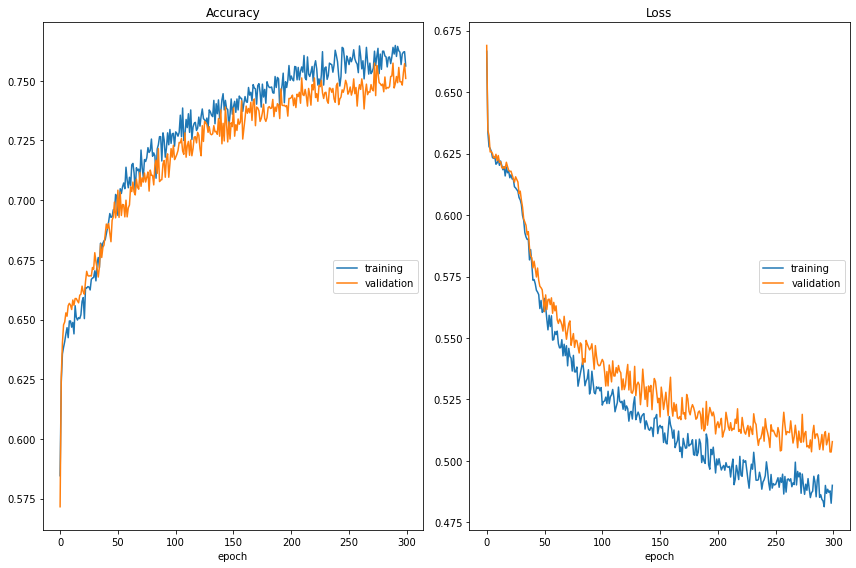

Accuracy
	training         	 (min:    0.585, max:    0.765, cur:    0.756)
	validation       	 (min:    0.572, max:    0.757, cur:    0.751)
Loss
	training         	 (min:    0.481, max:    0.667, cur:    0.490)
	validation       	 (min:    0.504, max:    0.669, cur:    0.508)


In [40]:
adpt_att_net,_ = train_adapt_model(adpt_att_net, adpt_trloader, adpt_criterion, adpt_optimizer, adpt_epochs, device, adpt_teloader)

In [43]:
Xtr = adpt_trloader.dataset.tensors[0]
ytr = adpt_trloader.dataset.tensors[1]
Xte =adpt_teloader.dataset.tensors[0]
yte = adpt_teloader.dataset.tensors[1]
Xte2 =adpt_teloader2.dataset.tensors[0]
yte2 = adpt_teloader2.dataset.tensors[1]


In [44]:
test_binary_model(adpt_att_net, adpt_teloader, adpt_criterion, device, 0.0)

(0.5035758018493652, 0.7512)

In [46]:
def get_prediction(model, testloader, device):
    model.to(device).eval()
    preds = []
    with torch.no_grad():
        for data in testloader:
            preds.append(model(data[0].to(device)).detach().cpu())
        preds = torch.cat(preds,dim=0)
    return preds

In [49]:
from sklearn.metrics import f1_score
preds = get_prediction(adpt_att_net, adpt_teloader,device)
preds_h = (preds>0.5).type(torch.FloatTensor).numpy()
print(f1_score(yte.numpy(), preds_h,pos_label=0))
print(f1_score(yte.numpy(), preds_h,pos_label=1))
print(f1_score(yte.numpy(), preds_h,average='weighted'))

0.6895849248790425
0.799275481640046
0.7522840471236321


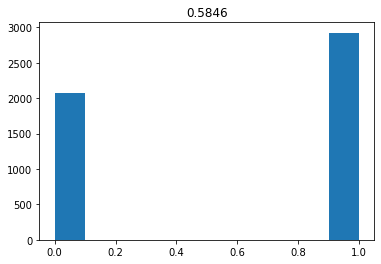

In [41]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(adpt_trloader.dataset.tensors[1].numpy())
plt.title(str(sum(adpt_trloader.dataset.tensors[1].numpy()==1)/len(adpt_trloader.dataset.tensors[1])))
plt.show()

In [21]:
adpt_trloader.dataset.tensors[1]

tensor([1., 1., 1.,  ..., 1., 1., 0.])

In [42]:
test_binary_model(adpt_att_net, adpt_teloader2, adpt_criterion, device, 0.0)

(0.6531950831413269, 0.633)

In [51]:
from sklearn.metrics import f1_score
preds2 = get_prediction(adpt_att_net, adpt_teloader2,device)
preds_h2 = (preds2>0.5).type(torch.FloatTensor).numpy()
print(f1_score(yte2.numpy(), preds_h2,pos_label=0))
print(f1_score(yte2.numpy(), preds_h2,pos_label=1))
print(f1_score(yte2.numpy(), preds_h2,average='weighted'))

0.3071090047393365
0.7517826825127335
0.6861043803056028


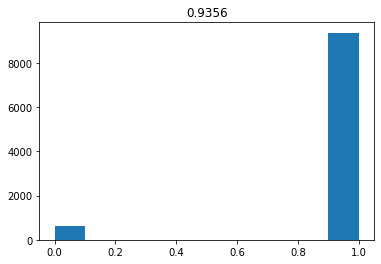

In [32]:
import matplotlib.pyplot as plt
ys = adpt_teloader2.dataset.tensors[1].numpy()
plt.figure()
plt.hist(ys)
plt.title(str(sum(ys==1)/len(ys)))
plt.show()